# **LayoutLM V3**


### Objectives for pre-training :-

1. Maksed Language Modelling 
    - Predicting the text in a patch of the document given 2d positonal embedding (Similar to Maksed Visual Language Modelling (MVLM))

2. Masked Image Modelling
    - Masking the image tokens and trying to predict them with the other context 

3. Word-Patch Alignement 
    - Predict whether the corresponding image patches of a text word are masked.



- #### Same attention mechanism as V2
- #### No need of a complete CNN encoder here for image embeddings, rather uses Vision-Transformer by dividing the image into patches
- #### Image patches are also positionally encoded and used here

## **Patch Embeddings**


    class LayoutLMv3PatchEmbeddings(nn.Module):

        def __init__(self, config):
            super().__init__()

            image_size = (
                config.input_size
                if isinstance(config.input_size, collections.abc.Iterable)
                else (config.input_size, config.input_size)
            )
            
            patch_size = (
                config.patch_size
                if isinstance(config.patch_size, collections.abc.Iterable)
                else (config.patch_size, config.patch_size)
            )

            self.patch_shape = (image_size[0] // patch_size[0], image_size[1] // patch_size[1])

            self.proj = nn.Conv2d(config.num_channels, config.hidden_size, kernel_size=patch_size, stride=patch_size)

        def forward(self, pixel_values, position_embedding=None):

            embeddings = self.proj(pixel_values)

            if position_embedding is not None:

                # interpolate the position embedding to the corresponding size
                position_embedding = position_embedding.view(1, self.patch_shape[0], self.patch_shape[1], -1)
                position_embedding = position_embedding.permute(0, 3, 1, 2)

                patch_height, patch_width = embeddings.shape[2], embeddings.shape[3]
                position_embedding = F.interpolate(position_embedding, size=(patch_height, patch_width), mode="bicubic")
                
                embeddings = embeddings + position_embedding

            embeddings = embeddings.flatten(2).transpose(1, 2)
            return embeddings


## **Text Embeddings**

#### 2D positional (spatial) embeddings for the text batches in the document image

    def calculate_spatial_position_embeddings(self, bbox):

        left_position_embeddings = self.x_position_embeddings(bbox[:, :, 0])
        upper_position_embeddings = self.y_position_embeddings(bbox[:, :, 1])
        right_position_embeddings = self.x_position_embeddings(bbox[:, :, 2])
        lower_position_embeddings = self.y_position_embeddings(bbox[:, :, 3])


        h_position_embeddings = self.h_position_embeddings(torch.clip(bbox[:, :, 3] - bbox[:, :, 1], 0, 1023))
        w_position_embeddings = self.w_position_embeddings(torch.clip(bbox[:, :, 2] - bbox[:, :, 0], 0, 1023))


        spatial_position_embeddings = torch.cat(
                    [
                        left_position_embeddings,
                        upper_position_embeddings,
                        right_position_embeddings,
                        lower_position_embeddings,
                        h_position_embeddings,
                        w_position_embeddings,
                    ],
                    dim=-1
        )

        return spatial_position_embeddings

############################################################################################################################

### Token type embeddings for texts 


    self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id) # (OR input_embeds)
    self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

    token_type_embeddings = self.token_type_embeddings(token_type_ids)

############################################################################################################################


#### NOTE:- Positional embeddings (2D and 1D) are already added to both image and text embeddings respectively.


    embeddings = inputs_embeds + token_type_embeddings

    # 1D textual positional embeddings 
    position_embeddings = self.position_embeddings(position_ids)
    embeddings += position_embeddings

    # 2D-spatial positional embeddings 
    spatial_position_embeddings = self.calculate_spatial_position_embeddings(bbox)

    embeddings = embeddings + spatial_position_embeddings

    embeddings = self.LayerNorm(embeddings)
    embeddings = self.dropout(embeddings)

## **Attention mechanism**
- CogView Attention 

        def cogview_attention(self, attention_scores, alpha=32):
 
                scaled_attention_scores = attention_scores / alpha
                max_value = scaled_attention_scores.amax(dim=(-1)).unsqueeze(-1)
                new_attention_scores = (scaled_attention_scores - max_value) * alpha
                return nn.Softmax(dim=-1)(new_attention_scores)


    attention_scores += (rel_pos + rel_2d_pos) / math.sqrt(self.attention_head_size)


Here, relative positional biases are added to the attetntion scores  

############################################################################################################################


#### **Relative positional biases for attention mechanism**


    rel_pos = self._cal_1d_pos_emb(position_ids) if self.has_relative_attention_bias else None
    rel_2d_pos = self._cal_2d_pos_emb(bbox) if self.has_spatial_attention_bias else None


    def relative_position_bucket(self, relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        ret = 0
        if bidirectional:
            num_buckets //= 2
            ret += (relative_position > 0).long() * num_buckets
            n = torch.abs(relative_position)
        else:
            n = torch.max(-relative_position, torch.zeros_like(relative_position))
            # now n is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = n < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        val_if_large = max_exact + (
            torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)
        ).to(torch.long)
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))

        ret += torch.where(is_small, n, val_if_large)
        return ret



    def _cal_1d_pos_emb(self, position_ids):
        rel_pos_mat = position_ids.unsqueeze(-2) - position_ids.unsqueeze(-1)

        rel_pos = self.relative_position_bucket(
            rel_pos_mat,
            num_buckets=self.rel_pos_bins,
            max_distance=self.max_rel_pos,
        )
        rel_pos = self.rel_pos_bias.weight.t()[rel_pos].permute(0, 3, 1, 2)
        rel_pos = rel_pos.contiguous()
        return rel_pos



    def _cal_2d_pos_emb(self, bbox):
        position_coord_x = bbox[:, :, 0]
        position_coord_y = bbox[:, :, 3]
        rel_pos_x_2d_mat = position_coord_x.unsqueeze(-2) - position_coord_x.unsqueeze(-1)
        rel_pos_y_2d_mat = position_coord_y.unsqueeze(-2) - position_coord_y.unsqueeze(-1)
        rel_pos_x = self.relative_position_bucket(
            rel_pos_x_2d_mat,
            num_buckets=self.rel_2d_pos_bins,
            max_distance=self.max_rel_2d_pos,
        )
        rel_pos_y = self.relative_position_bucket(
            rel_pos_y_2d_mat,
            num_buckets=self.rel_2d_pos_bins,
            max_distance=self.max_rel_2d_pos,
        )
        rel_pos_x = self.rel_pos_x_bias.weight.t()[rel_pos_x].permute(0, 3, 1, 2)
        rel_pos_y = self.rel_pos_y_bias.weight.t()[rel_pos_y].permute(0, 3, 1, 2)
        rel_pos_x = rel_pos_x.contiguous()
        rel_pos_y = rel_pos_y.contiguous()
        rel_2d_pos = rel_pos_x + rel_pos_y
        return rel_2d_pos

############################################################################################################################


## **Forward pass** 

### 1. Textual embedddings 

        embedding_output = self.embeddings(
                    input_ids=input_ids,
                    bbox=bbox,
                    position_ids=position_ids,
                    token_type_ids=token_type_ids,
                    inputs_embeds=inputs_embeds,
                )

    
### 2. Image patches embeddings 

        def forward_image(self, pixel_values):
            embeddings = self.patch_embed(pixel_values)

        where, self.patch_embed = LayoutLMv3PatchEmbeddings(config)

        *
        visual_embeddings = self.forward_image(pixel_values)


### 3. Concatenating visual and textual embeddings 

        embedding_output = torch.cat([embedding_output, visual_embeddings], dim=1)
        embedding_output = self.LayerNorm(embedding_output)
        embedding_output = self.dropout(embedding_output)

### 4. Passing through encoder

        encoder_outputs = self.encoder(
            embedding_output,
            bbox=final_bbox,
            position_ids=final_position_ids,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            patch_height=patch_height,
            patch_width=patch_width,
        )

        sequence_output = encoder_outputs[0]

        return sequence_output

In [4]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, low_cpu_mem_usage = False)

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
image.save("astronaut_rides_horse.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Patch embeds1 shape =  torch.Size([1, 1024, 16, 16])
Patch embeds2 shape =  torch.Size([1, 256, 1024])
class embeds shape =  torch.Size([1, 1, 1024])

position ids =  tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146,

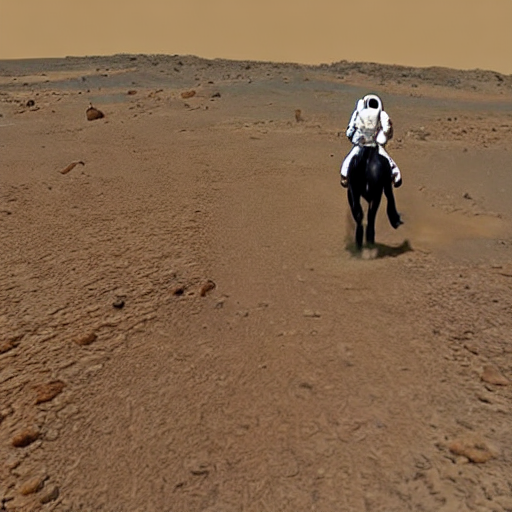

In [6]:
image

  0%|          | 0/50 [00:00<?, ?it/s]

Patch embeds1 shape =  torch.Size([1, 1024, 16, 16])
Patch embeds2 shape =  torch.Size([1, 256, 1024])
class embeds shape =  torch.Size([1, 1, 1024])

position ids =  tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146,

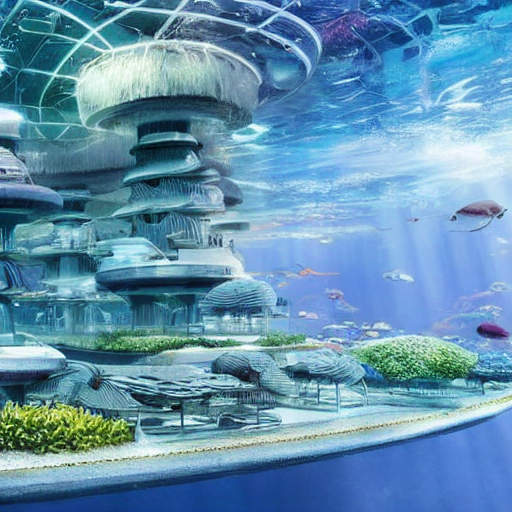

In [7]:
prompt = "Underwater sky city in Indian ocean from the future"
image = pipe(prompt).images[0]  
    
image